<a href="https://colab.research.google.com/github/yongjulee0213/KLUE/blob/main/%ED%95%9C%EC%98%81%EB%AA%A8%EB%8D%B8%EC%A0%9C%EC%9E%91_0121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/PJ3_Translator')
print(sys.path)

['/content', '/env/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/PJ3_Translator']


In [3]:
import pandas as pd
import csv

In [4]:
spoken_train_path='/content/drive/MyDrive/PJ3_Translator/spoken_train.csv'
spoken_valid_path='/content/drive/MyDrive/PJ3_Translator/spoken_valid.csv'
spoken_test_path='/content/drive/MyDrive/PJ3_Translator/spoken_test.csv'

spoken_train=pd.read_csv(spoken_train_path)
spoken_valid=pd.read_csv(spoken_valid_path)
spoken_test=pd.read_csv(spoken_test_path)

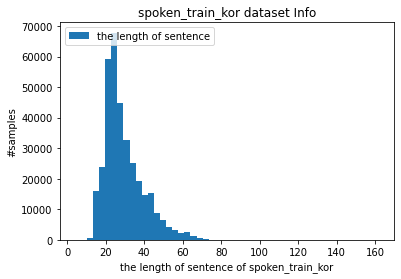

NameError: ignored

In [5]:
#histogram
import matplotlib.pyplot as plt

def histogram(lens,type_name):
  plt.hist(lens,bins=50,label='the length of sentence')
  plt.xlabel(f'the length of sentence of {type_name}')
  plt.ylabel('#samples')
  plt.legend(loc='upper left')
  plt.title(f'{type_name} dataset Info')
  plt.show()
  print(f'- max = {np.max(lens)} | min = {np.min(lens)} | mean = {np.mean(lens):.2f} | std = {np.std(lens):.2f} | median = {np.median(lens)} | "제1사분위수" = {np.quantile(lens,0.25)} | "제3사분위수" = {np.quantile(lens,0.75)}')

def EDA(dataset,type_name):
  length_kor,length_eng=[],[]
  for i in range(len(dataset)):
    length_kor.append(len(dataset['Kor'][i]))
    length_eng.append(len(dataset['Eng'][i]))

  #histogram & print
  histogram(length_kor,type_name=f'{type_name}_kor')
  histogram(length_eng,type_name=f'{type_name}_eng')

EDA(spoken_train,'spoken_train')
print('-------------------------------------------------------------')
EDA(spoken_valid,'spoken_valid')
print('-------------------------------------------------------------')
EDA(spoken_test,'spoken_test')

In [ ]:
!pip install transformers
!pip install sentencepiece

In [ ]:
#baseline train
import sentencepiece
from typing import Dict, List
import csv

from transformers import (
    EncoderDecoderModel,
    PreTrainedTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Trainer,
    GPT2Tokenizer,
    GPT2Model,
    ElectraTokenizer,
    ElectraModel
)

import torch

from transformers.models.encoder_decoder.modeling_encoder_decoder import EncoderDecoderModel


In [ ]:
class PairedDataset:
    def __init__(self, 
        src_tokenizer: PreTrainedTokenizer, tgt_tokenizer: PreTrainedTokenizer,
        file_path: str
    ):
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = tgt_tokenizer
        with open(file_path, 'r') as fd:
            self.data = [row[1:] for row in csv.reader(fd)]

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        src, trg = self.data[index]
        embeddings = self.src_tokenizer(src, return_attention_mask=False, return_token_type_ids=False)
        embeddings['labels'] = self.trg_tokenizer(trg, return_attention_mask=False)['input_ids']

        return embeddings

    def __len__(self):
        return len(self.data)

'''
class GPT2Tokenizer(BaseGPT2Tokenizer):
    def build_inputs_with_special_tokens(self, token_ids: List[int], _) -> List[int]:
        return token_ids + [self.eos_token_id]
'''

'\nclass GPT2Tokenizer(BaseGPT2Tokenizer):\n    def build_inputs_with_special_tokens(self, token_ids: List[int], _) -> List[int]:\n        return token_ids + [self.eos_token_id]\n'

In [ ]:

#%%


src_tokenizer = ElectraTokenizer.from_pretrained('monologg/koelectra-base-v3-finetuned-korquad')
trg_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

dataset = PairedDataset(src_tokenizer, trg_tokenizer, '/content/drive/MyDrive/PJ3_Translator/spoken_train.csv')
eval_dataset = PairedDataset(src_tokenizer, trg_tokenizer, '/content/drive/MyDrive/PJ3_Translator/spoken_valid.csv')

# %%

model = EncoderDecoderModel.from_encoder_decoder_pretrained(
    'monologg/koelectra-base-v3-finetuned-korquad',
    'gpt2',
    pad_token_id=trg_tokenizer.bos_token_id
)

#model = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/PJ3_Translator/test1_dump/best_model')#이전에 학습시켰던 dump 중 best_model들고오기
model.config.decoder_start_token_id = trg_tokenizer.bos_token_id

# %%
collator = DataCollatorForSeq2Seq(src_tokenizer, model)

arguments = Seq2SeqTrainingArguments(
    output_dir='content/drive/MyDrive/PJ3_Translator/test3_dump',
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=18,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    gradient_accumulation_steps=4,
    save_total_limit=5,
    dataloader_num_workers=2,
    fp16=True,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model,
    arguments,
    data_collator=collator,
    train_dataset=dataset,
    eval_dataset=eval_dataset
)

trainer.train()

model.save_pretrained("/content/drive/MyDrive/PJ3_Translator/test2_dump/best_model")
# %%

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--monologg--koelectra-base-v3-finetuned-korquad/snapshots/ea97b35e21bfd7f2524b5697931ae3db0394af9f/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--monologg--koelectra-base-v3-finetuned-korquad/snapshots/ea97b35e21bfd7f2524b5697931ae3db0394af9f/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--monologg--koelectra-base-v3-finetuned-korquad/snapshots/ea97b35e21bfd7f2524b5697931ae3db0394af9f/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--monologg--koelectra-base-v3-finetuned-korquad/snapshots/ea97b35e21bfd7f2524b5697931ae3db0394af9f/config.json
Model config ElectraConfig {
  "_name_or_path": "monologg/koelectra-base-v3-finetuned-korquad",
  "architectures": [
    "ElectraForQuestionAnswering"
  ],


Epoch,Training Loss,Validation Loss
1,1.846600,1.761927
2,1.657700,1.637390
3,1.475600,1.554728
4,1.322200,1.523653
5,1.206500,1.520092
6,1.118700,1.528969
7,1.029200,1.550566
8,0.955700,1.583310
9,0.884100,1.613178
10,0.829600,1.641006


***** Running Evaluation *****
  Num examples = 50001
  Batch size = 16
Saving model checkpoint to test2_dump/checkpoint-5469
Configuration saved in test2_dump/checkpoint-5469/config.json
Model weights saved in test2_dump/checkpoint-5469/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
***** Running Evaluation *****
  Num examples = 50001
  Batch size = 16
Saving model checkpoint to test2_dump/checkpoint-10938
Configuration saved in test2_dump/checkpoint-10938/config.json
Model weigh

In [ ]:
src_tokenizer = ElectraTokenizer.from_pretrained('monologg/koelectra-base-v3-finetuned-korquad')
trg_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

model = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/PJ3_Translator/test2_dump/best_model')#이전에 학습시켰던 dump 중 best_model들고오기
model.eval()
model.cuda()
model.config.decoder_start_token_id = trg_tokenizer.bos_token_id

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--monologg--koelectra-base-v3-finetuned-korquad/snapshots/ea97b35e21bfd7f2524b5697931ae3db0394af9f/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--monologg--koelectra-base-v3-finetuned-korquad/snapshots/ea97b35e21bfd7f2524b5697931ae3db0394af9f/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--monologg--koelectra-base-v3-finetuned-korquad/snapshots/ea97b35e21bfd7f2524b5697931ae3db0394af9f/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--monologg--koelectra-base-v3-finetuned-korquad/snapshots/ea97b35e21bfd7f2524b5697931ae3db0394af9f/config.json
Model config ElectraConfig {
  "_name_or_path": "monologg/koelectra-base-v3-finetuned-korquad",
  "architectures": [
    "ElectraForQuestionAnswering"
  ],


In [ ]:
spoken_test

,Unnamed: 0,Kor,Eng
0,0,사과는 잘 씻은 뒤 껍질 채 먹는 게 좋다네요.,It's healthier to eat the apple with its skin ...
1,1,내가 언제까지 거기 가면 됩니까?,Untill when should I be there?
2,2,우리가 작성해서 전달해 드려야 하나요?,Do we have to write and transmit it?
3,3,"난 지금 행복해요, 세상이 나를 원하고 있죠.","I’m happy now, this world wants me."
4,4,그는 틀림없이 꽃 가게에 들렸을 겁니다.,He must have dropped by a flower shop.
...,...,...,...
99995,19995,그럼 컨셉을 약간 바꾸는 것도 좋은 방법이겠네요.,Then it might be a good idea to change the con...
99996,19996,객실 안에 비밀번호가 작성되어 있습니다.,The password is written in your room.
99997,19997,4번 게이트로 갔을 때 바로 찾을 수 있나요?,Can I find it right away if I go to gate no.4?
99998,19998,지금 3개나 빠진 상태인데 한꺼번에 이렇게 많이 빠져도 상관없는 건가요?,"The child already has three missing teeth, are..."


In [ ]:
#-------------변경해야함--------------------------------
preds=[]
for i in range(len(spoken_test)):
  text = spoken_test['Kor'][i]
  embeddings = src_tokenizer(text, return_attention_mask=False, return_token_type_ids=False, return_tensors='pt')
  #print(text, embeddings)
  embeddings = {k: v.cuda() for k, v in embeddings.items()}
  output = model.generate(**embeddings)[0, 1:-1]
  preds.append(trg_tokenizer.decode(output.cpu()))
  print(trg_tokenizer.decode(output.cpu()),len(preds))


/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Fix the crack line of red square. (Note: It is repaired. The crack line 1343
It is a small size for traveling abroad and is suitable for gift-giving for visiting Korea 1344
There are many ways to keep your manners in life. I think there are many ways to 1345
On the other hand, the reason for Korea is reasonable. It is rational. It is 1346
When I see beauty, I see external things. I see things outside. I see things 1347
We will buy some detergents and disinfectants and do it ourselves. We will do 1348
We would be very happy if we could upgrade the room. We would be very happy. 1349
There are no guys who ask you out. You don't have to. You don't 1350
I am an artist who can express myself. I am an artist who can express myself. 1351
The nature of Alaska is constantly being destroyed.......... 1352
You know I always wait for you, right? You know I always wait for you. 1353
But still, do you want to turn off the notifications? Yes. I want t

KeyboardInterrupt: ignored

In [ ]:
len(preds)

6342

In [ ]:

df_sub_with_Eng = pd.DataFrame({'Korean' : spoken_test['Kor'][:3000], 'English' : spoken_test['Eng'][:3000], 'prediction' : preds[:3000]})
#변경해야함
df_sub = pd.DataFrame({'Korean' : spoken_test['Kor'][:3000], 'English' : spoken_test['Eng'][:3000], 'prediction' : preds[:3000]})

In [ ]:
df_sub_with_Eng

,Korean,English,prediction
0,사과는 잘 씻은 뒤 껍질 채 먹는 게 좋다네요.,It's healthier to eat the apple with its skin ...,They say that it is good to eat apples after w...
1,내가 언제까지 거기 가면 됩니까?,Untill when should I be there?,Until when should I go there?. (Note: I will b...
2,우리가 작성해서 전달해 드려야 하나요?,Do we have to write and transmit it?,Should we fill out and deliver it? We have to....
3,"난 지금 행복해요, 세상이 나를 원하고 있죠.","I’m happy now, this world wants me.","I'm happy now, the world wants me. The world w..."
4,그는 틀림없이 꽃 가게에 들렸을 겁니다.,He must have dropped by a flower shop.,He must have been at the flower shop. He must ...
...,...,...,...
2995,그는 꼭 비밀을 지킬 것입니다.,He's supposed to keep his own counsel.,He will keep the secret. He will. keep the sec...
2996,나의 군대 후임이 용 문신을 했어요.,One of my military juniors got a dragon tattoo.,My second lieutenant tattooed a dragon. I wore...
2997,비즈니스는 전부터 어려웠지만 F에서 시작해서 B까지 올린 경험이 있습니다.,"Business was difficult from the beginning, but...","The business has been difficult before, but I ..."
2998,아직 담당자에게서 회신을 받지 못했습니다.,I haven't received a reply from the manager yet.,I haven't received a reply from the person in ...


In [ ]:
df_sub_with_Eng.to_csv('/content/drive/MyDrive/PJ3_Translator/spoken2eng_with_original_Eng.csv')
df_sub.to_csv('/content/drive/MyDrive/PJ3_Translator/spoken2eng.csv')